In [1]:
from datasets import load_dataset
import matplotlib.pyplot as plt
# Modeling
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Resize

from ecallisto_dataset import (
    preprocess_spectrogram,
    EcallistoDatasetBinary,
    CustomSpecAugment,
    custom_resize_max
)

import pandas as pd

print(f'PyTorch version {torch.__version__}')
# Check if CUDA is available
if torch.cuda.is_available():
    print(f"GPU is available: {torch.cuda.get_device_name(0)}")
    device = 'cuda'
else:
    print("GPU is not available.")
    device = 'cpu'

/home/vincenzo/miniconda3/envs/flaresense-v2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version 2.3.0+cu121
GPU is not available.


In [2]:
ds = load_dataset('i4ds/radio-sunburst-ecallisto-paths-df')

In [16]:
# Transforms
resize_func = Compose(
    [
        lambda x: custom_resize_max(x, (224, 224)),  # Resize the image
    ]
)
data_augm_transform = CustomSpecAugment(
    frequency_masking_para=30, method='max'
)


In [17]:
# Transforms

# Data Loader
ds_test = EcallistoDatasetBinary(
    ds['test'],
    resize_func=resize_func,
    data_augm_transform=data_augm_transform,
    normalization_transform=preprocess_spectrogram,
)


test_dataloader = DataLoader(
    ds_test,
    batch_size=1,
    num_workers=1,
    shuffle=False,
    persistent_workers=True,
)


In [18]:
with torch.no_grad():
    for example in test_dataloader:
        example = example
        break

torch.Size([193, 3600])
torch.Size([193, 3600])
torch.Size([224, 224])
torch.Size([224, 224])


In [19]:
example

[tensor([[[1.0000, 0.1121, 0.1207,  ..., 0.4483, 0.5862, 0.7241],
          [0.1121, 0.1207, 0.1293,  ..., 0.1293, 0.1293, 0.1293],
          [0.1034, 0.1293, 0.1466,  ..., 0.1379, 0.1552, 0.1638],
          ...,
          [0.1207, 0.1121, 0.1121,  ..., 0.1207, 0.1207, 0.1207],
          [0.1207, 0.1121, 0.1121,  ..., 0.1207, 0.1207, 0.1207],
          [0.1207, 0.1121, 0.1121,  ..., 0.1207, 0.1207, 0.1207]]]),
 tensor([0]),
 ('ALASKA-COHOE_63',),
 ('2023-02-27_18-46-00',)]

In [21]:
ds['test'][0]

{'file_path': '/mnt/nas05/data01/vincenzo/ecallisto/data/ALASKA-COHOE_63/0/2023-02-27_18-46-00.parquet',
 'label': 0,
 'antenna': 'ALASKA-COHOE_63',
 'datetime': '2023-02-27_18-46-00'}

In [22]:
df = pd.read_parquet('/mnt/nas05/data01/vincenzo/ecallisto/data/ALASKA-COHOE_63/0/2023-02-27_18-46-00.parquet')

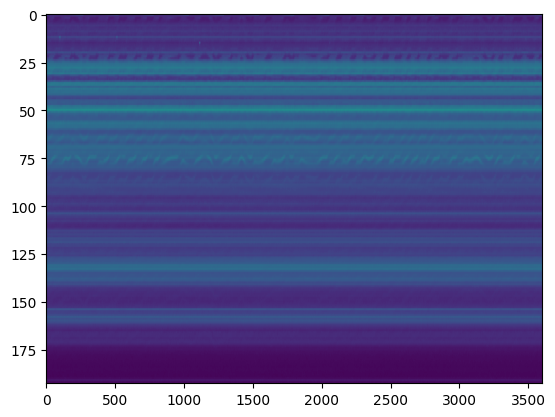

In [23]:
plt.imshow(df.T, aspect='auto')

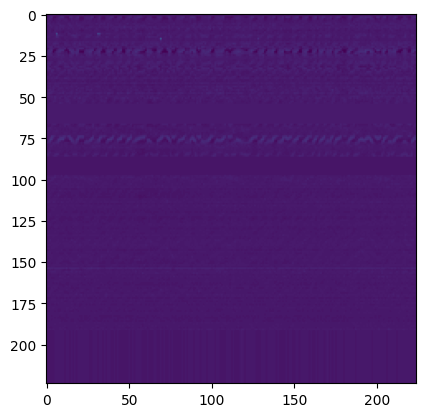

In [24]:
plt.imshow(example[0].squeeze().numpy())